# Import libraries

In [ ]:
from google import colab
colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
import networkx as nx
import plotly.express as px
from mlxtend.frequent_patterns import association_rules, apriori
warnings.filterwarnings('ignore')
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data Input

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/COM6101_Group Project/Dateset from Kaggle/Data Analysis for Marketing Strategy/Sample - Superstore.csv', encoding='Windows-1252')

In [ ]:
df.drop(columns=['Row ID'], inplace = True )

## Dataframe information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9994 non-null   float64
 17  Quantity       9994 non-null   int64  
 18  Discount

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


## **Data Cleaning**

## Missing value checking

In [ ]:
df.isna().sum()

,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0
State,0


Based on the above result, there is no missing values.

## Check Duplicated

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
9989,False
9990,False
9991,False
9992,False


Based on the above result, there is no duplicated values.

# 1) **Data exploration**

## State information update

In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

## Background Information

### Customer Distruibution across the country

In [ ]:
import plotly.graph_objects as go

# Create new column with State Abbreviations
df['State_abb'] = df['State'].replace(us_state_to_abbrev)

# Plot
fig = go.Figure(data=[go.Choropleth(
    locations=df['State_abb'].value_counts().index,  # Spatial coordinates
    z=df['State_abb'].value_counts(),  # Data to be color-coded
    locationmode='USA-states',
    colorscale='teal',
    zmin=1,
    zmax=1000
)])

fig.update_layout(
    font=dict(size=14),
    title={
        'text': "Number of Customers by State Map",
        'y': 0.95,
        'x': 0.5
    },
    geo_scope='usa'  # limite map scope to USA
)

fig.show()

### Shipping Mode Distribution

In [ ]:
fig = px.bar(x = df['Ship Mode'].value_counts().index, y = df['Ship Mode'].value_counts(),
             color = df['Ship Mode'].value_counts().index,)

#Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Shipping Mode",
    yaxis_title="Number of Orders",
    showlegend = False,
    font = dict(
            size = 14
            ),
    title={
        'text': "Frequency of Orders by Shipping Modes",
        'y':0.95,
        'x':0.5
        }
    )

fig.show()

### Frequency of Orders by Segment

In [ ]:
fig = px.bar(x = df['Segment'].value_counts().index, y = df['Segment'].value_counts(),
             color = df['Segment'].value_counts().index,
             )

#Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Number of Orders",
    showlegend = False,
    font = dict(
            size = 14
            ),
    title={
        'text': "Frequency of Orders by Segment",
        'y':0.95,
        'x':0.5
        }
    )

fig.show()

### Frequency of Orders by Category

In [ ]:
fig = px.bar(x = df['Category'].value_counts().index, y = df['Category'].value_counts(),
             color = df['Category'].value_counts().index,
             )

#Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Category",
    yaxis_title="Number of Orders",
    showlegend = False,
    font = dict(
            size = 14
            ),
    title={
        'text': "Frequency of Orders by Category",
        'y':0.95,
        'x':0.5
        }
    )

fig.show()

### Frequency of Orders by Sub-Category

In [ ]:
fig = px.bar(x = df['Sub-Category'].value_counts().index, y = df['Sub-Category'].value_counts(),
             )

#Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Sub-Category",
    yaxis_title="Number of Orders",
    font = dict(
            size = 14
            ),
    title={
        'text': "Frequency of Orders by Sub-Category",
        'y':0.95,
        'x':0.5
        }
    )

fig.show()

## Sales Analysis

###  Sales figures across four different regions: Central, East, South, and West

In [ ]:
region_vs_sales = df.groupby('Region')['Sales'].sum().reset_index()

<Axes: xlabel='Region', ylabel='Sales'>

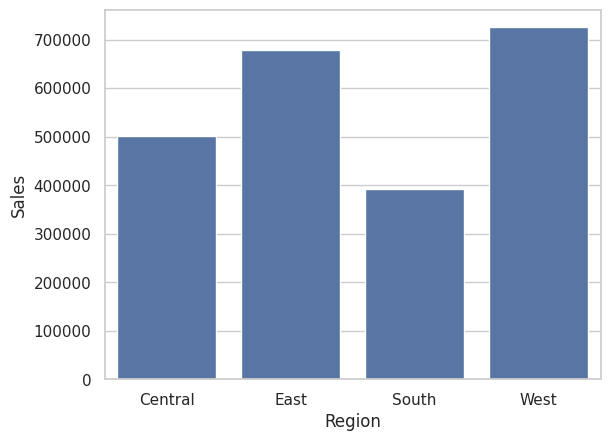

In [ ]:
sns.barplot(region_vs_sales,x='Region' , y='Sales')

West Region Leads in Sales: The West region has the highest sales among the four, significantly surpassing the other regions. This indicates a strong market or high-performing sales team in the West.

East Region Shows Strong Performance: The East region also exhibits substantial sales, coming in second place. It suggests a robust market or effective sales strategies in this area.

South Region Has the Lowest Sales: The South region has the lowest sales compared to the other three. This could point to a weaker market, less effective sales efforts, or other factors affecting sales in this region.

Central Region Shows Moderate Sales: The Central region has moderate sales, falling between the East and South regions. It indicates a reasonably performing market but with room for improvement compared to the West and East.

### The relationship between "Discount" and both "Sales" and "Profit"

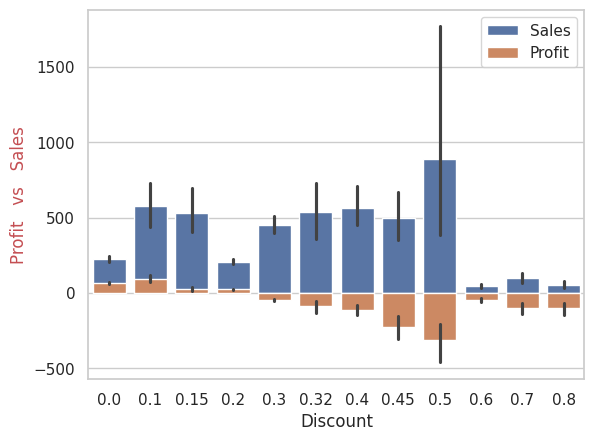

In [ ]:
sns.barplot(df , x='Discount',y='Sales' ,label = 'Sales')
sns.barplot(df , x='Discount',y='Profit' , label = 'Profit')
plt.ylabel('Profit   vs   Sales', color ='r')
plt.show()

Sales Generally Increase with Discount: Sales tend to increase as the discount increases, especially up to a discount of 0.5.

Profit Fluctuates with Discount: Profit shows a more volatile pattern. It initially increases with small discounts but then declines significantly with higher discounts.

Optimal Discount Range: The optimal discount range for maximizing profit appears to be between 0.1 and 0.3. Beyond 0.3, the profit starts to decline, suggesting that higher discounts may not be beneficial in terms of profitability.

High Discount (0.5) Leads to High Sales but Negative Profit: At a discount of 0.5, there is a substantial increase in sales, but the profit turns negative. This implies that while higher discounts can drive sales volume, they may not translate to actual profit.

Low Discount (0.0) Results in Moderate Sales and Positive Profit: At a discount of 0.0, there are moderate sales with positive profit. This indicates that even without discounts, there is a base level of sales and profit.

## Product Analysis

### Hot selling items over Sales amount and Quantity

In [ ]:
product_sales = df.groupby('Product Name').agg({ 'Sales' :'sum',
                              'Quantity':'sum'
    }).reset_index().sort_values('Sales' ,ascending=False)

In [ ]:
fig= px.bar(product_sales[:10] ,x='Sales' ,y='Product Name', orientation='h' ,color='Quantity' , text = 'Quantity'
            , title ='The Most selling products in the superstore over Sales amount and Quantity' )
fig.update_traces(textposition='outside')

Based on the graph, here are some findings

1. Canon ImageCLASS 2200 Advanced Copier Dominates Sales: This product has significantly higher sales compared to all other products, indicating a strong market presence or high price point. However, the quantity sold is only 20, suggesting that it's a high-value item sold in relatively low volumes.

2. Quantity vs. Sales Correlation is Varied: While some products show a correlation between higher sales and higher quantities (e.g., GBC DocuBind P400 Electric Binding System), others do not (e.g., Canon ImageCLASS 2200). This suggests that price per unit varies significantly across products.

3. GBC Ibimaster 500 Manual ProClick Binding System Stands Out for Quantity: This product has the highest quantity sold (48) among the top 10, indicating it's a popular item, likely due to its affordability or widespread use.

4. High-Value Items with Lower Quantity: Products like Cisco TelePresence System EX90 Videoconferencing Unit and HP DesignJet T520 Inkjet Large Format Printer - 24" Color have lower quantities but still appear in the top 10 for sales, implying they are high-priced items.

5. Mid-Range Sales and Quantity: Several products, such as GBC DocuBind TL300 Electric Binding System, HON 5400 Series Task Chairs for Big and Tall, and Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind, show a balance between sales and quantity, suggesting a stable market for these items.

## Category Analysis

### The profit margin across Furniture, Office Supplies, and Technology

In [ ]:
df['Profit Margin'] =df['Profit']/df['Sales']
margine_per_category = df.groupby('Category')['Profit Margin'].mean().reset_index()

<Axes: xlabel='Category', ylabel='Profit Margin'>

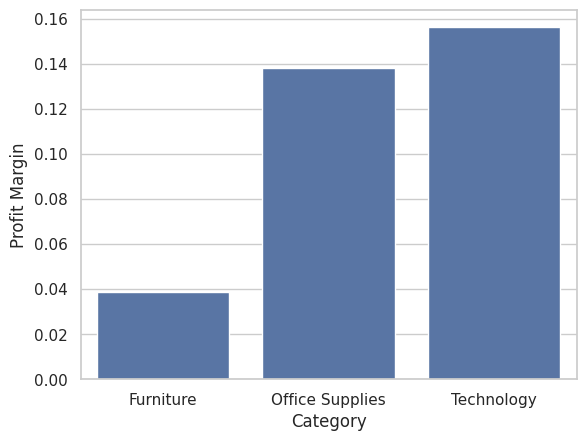

In [ ]:
sns.barplot(margine_per_category,x='Category',y= 'Profit Margin')

The graph clearly shows that the Technology category is the most profitable, followed by Office Supplies, while the Furniture category has the lowest profit margin.

### The number of orders for various sub-categories

In [ ]:
subcategory_demand= df.groupby('Sub-Category').agg(
    {'Order ID':'count' ,
    'Category':'first'}
    ).reset_index().sort_values('Order ID',ascending=False).rename({'Order ID':'Number of Orders'},axis=1)

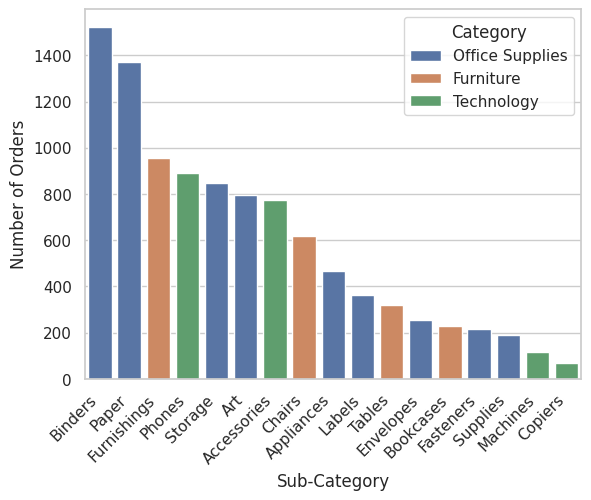

In [ ]:
sns.barplot(subcategory_demand,x='Sub-Category' ,y='Number of Orders',hue='Category')
plt.xticks(rotation =45 ,ha ='right')
plt.show()

*   Binders and Paper are Top Ordered Items: The "Binders" and "Paper" sub-categories have the highest number of orders, significantly surpassing all other sub-categories. Both belong to the "Office Supplies" category.

*   Office Supplies Dominate in Order Volume: The "Office Supplies" category has the most sub-categories and generally the highest order volume, indicating a strong demand for these products.
Furniture Sub-Categories Show Moderate Orders: The "Furniture" sub-categories, such as "Furnishings" and "Chairs," show a moderate number of orders, falling in the mid-range.


*   Technology Sub-Categories Have Lower Order Volume: The "Technology" sub-categories, like "Phones" and "Copiers," generally have lower order volumes compared to "Office Supplies," with "Copiers" having the lowest orders overall.


## Profit Analysis

### Sales and profit for three categories: Furniture, Office Supplies, and Technology

In [ ]:
category_vs_sales_profit =df.groupby('Category').agg({
    'Sales' : 'sum' ,
    'Profit' : 'sum'}).reset_index()
lst= ['Sales','Profit']

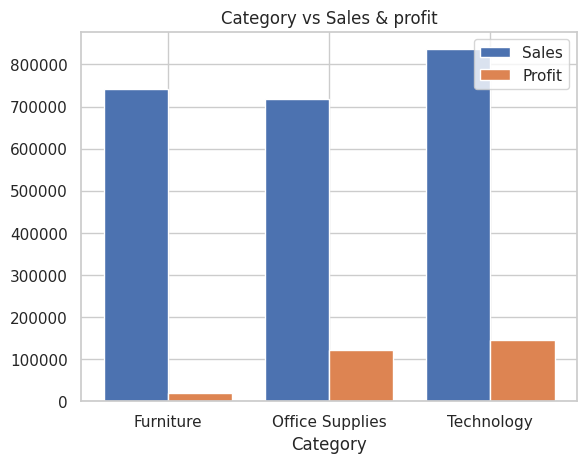

In [ ]:
x = np.arange(len(category_vs_sales_profit['Category']))

plt.bar(x-.2  ,category_vs_sales_profit['Sales'] , .4 ,label ='Sales')
plt.bar(x+.2  ,category_vs_sales_profit['Profit'] , .4 ,label = 'Profit')
plt.xticks(x , category_vs_sales_profit['Category'])


plt.xlabel('Category')
plt.title("Category vs Sales & profit")
plt.legend(loc = 'upper right')
plt.show()



*   Technology Category Leads in Both Sales and Profit: The Technology category has the highest sales and profit compared to the other two categories. This indicates that Technology products are the most lucrative.

*   Office Supplies Category Shows Moderate Sales and Profit: The Office Supplies category has moderate sales and profit, falling between Furniture and Technology.

*   Furniture Category Has the Lowest Sales and Profit: The Furniture category has the lowest sales and profit among the three. This suggests that furniture products are the least profitable.

*   Profit Margin Variation: The profit margin (the ratio of profit to sales) varies across categories. While Technology has the highest sales and profit, its profit margin is not dramatically higher than Office Supplies. Furniture has the lowest sales and profit, and its profit margin is also notably low.

*   Sales and Profit Correlation: There is a positive correlation between sales and profit; categories with higher sales tend to have higher profits.

### Profit Margin by Category & Sub-Category

In [ ]:
# Calculate profit margin per sub-category directly from transactions
margin_per_subcategory = df.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().reset_index()
margin_per_subcategory['Profit Margin'] = (margin_per_subcategory['Profit'] / margin_per_subcategory['Sales']) * 100


# Plot using px.bar
fig = px.bar(
    margin_per_subcategory,
    x='Profit Margin',
    y='Sub-Category',
    color='Category',
    orientation='h',
    template='simple_white',
    color_discrete_sequence=np.flip(['#636EFA', '#EF553B', '#00CC96'])
)

# Update layout
fig.update_layout(
    xaxis_title="Profit Margin (%)",
    yaxis_title="Sub-Category",
    legend_title="Category",
    showlegend=True,
    font={'size': 14},
    title={'text': "Profit Margin by Category & Sub-Category", 'y': 0.95, 'x': 0.5}
)

fig.show()

*   High Profit Margin in Office Supplies: Several sub-categories within "Office Supplies" show high profit margins, particularly "Paper," "Labels," and "Envelopes." This indicates that these products are highly profitable.

*   Technology Sub-Categories Show Mixed Profit Margins: The "Technology" sub-categories have varying profit margins. "Copiers" and "Accessories" show relatively high profit margins, while "Phones" and "Machines" have lower margins.

*   Furniture Sub-Categories Show Low or Negative Profit Margins: Most "Furniture" sub-categories exhibit low or even negative profit margins. "Bookcases" have the lowest profit margin, followed by "Tables" and "Chairs."

*   Significant Variation in Profit Margins: There is a significant variation in profit margins across different sub-categories, ranging from negative percentages to high positive percentages.

*   Potential Issues with Furniture Category: The low or negative profit margins in the "Furniture" category suggest potential issues such as high costs, low pricing, or poor sales performance.

*   High Profit Potential in Specific Office Supplies: The high profit margins in specific "Office Supplies" sub-categories indicate a strong potential for profitability in these product lines.

### Total Profit by Sub-Category

In [ ]:
# Calculate total profit per sub-category and sort in descending order
profit_per_sub_category = df.groupby('Sub-Category')['Profit'].sum().reset_index()
profit_per_sub_category = profit_per_sub_category.sort_values(by=['Profit'], ascending=False)

# Define colors explicitly
colors = ['#636EFA']  # You can add more colors if needed

# Customize colors using a list comprehension for better readability
new_colors = [
    '#FF69B4' if sub_category in ['Tables', 'Bookcases', 'Supplies'] else colors[0]
    for sub_category in profit_per_sub_category['Sub-Category']
]

# Plot using px.bar
fig = px.bar(
    profit_per_sub_category,
    x='Sub-Category',
    y='Profit',
    template='simple_white',
    color='Sub-Category',  # Use 'Sub-Category' for color mapping
    color_discrete_sequence=new_colors
)

# Update layout
fig.update_layout(
    xaxis_title="Sub-Category",
    yaxis_title="Profit",
    showlegend=False,
    font={'size': 14},
    title={'text': "Total Profit by Sub-Category", 'y': 0.95, 'x': 0.5}

)
fig.update_xaxes(tickangle=45)
fig.show()

## Time Factors Analysis

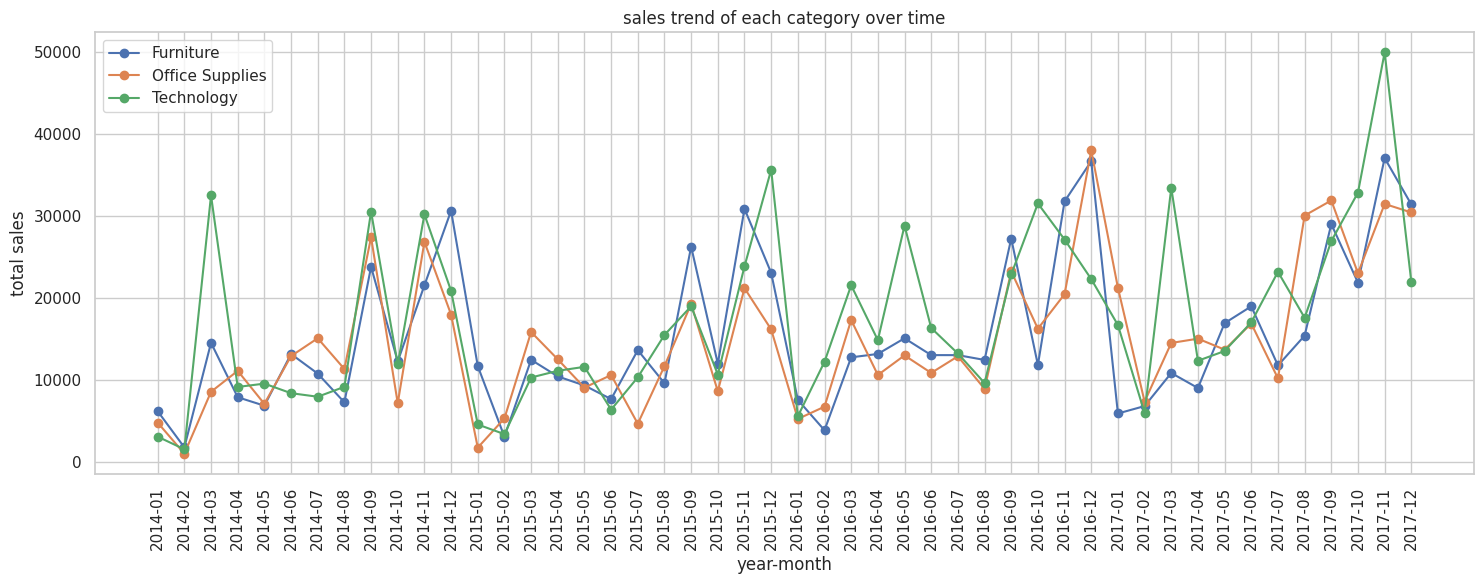

In [ ]:
# extract the year and month from the order date
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# analyze the sales trend of each category over time
category_time_sales = df.groupby(['Year', 'Month', 'Category'])['Sales'].sum().reset_index()
category_time_sales['YearMonth'] = category_time_sales['Year'].astype(str) + '-' + category_time_sales['Month'].astype(str).str.zfill(2)

# plot the sales trend
plt.figure(figsize=(15, 6))
for category in df['Category'].unique():
    category_data = category_time_sales[category_time_sales['Category'] == category]
    plt.plot(category_data['YearMonth'], category_data['Sales'], marker='o', label=category)

plt.title('sales trend of each category over time')
plt.xlabel('year-month')
plt.ylabel('total sales')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### Sales Trend Analysis

The sales trend chart indicates:

- **Significant fluctuations** in sales over time across all three categories.
- **Technology products** exhibit **noticeable sales peaks** in certain months, especially in **late 2017**.
- While there is **some correlation** between the sales trends of the three categories, each category also shows **distinct independent fluctuations**.
- Overall, sales revenue **increased significantly in late 2017**.

### Analysis Conclusion:
The sales data demonstrates **seasonal variations**, which may be linked to **corporate purchasing cycles** or **promotional activities**. The sales peaks in technology products might be associated with **new product releases** or **year-end budget spending**.

These temporal patterns are valuable for **recommendation systems**, supporting the rationale for **applying stricter time decay for technology products**.

## Supply Chain Analysis

In [ ]:
# Calculate Shipping Time and group by Ship Mode
df['Shipping Time'] = (pd.to_datetime(df['Ship Date']) -
                                 pd.to_datetime(df['Order Date'])).dt.days
ship_mode_and_time = df.groupby('Ship Mode')['Shipping Time'].mean().reset_index()

# Plot
fig = px.bar(ship_mode_and_time,
             x='Ship Mode',
             y='Shipping Time',
             color='Ship Mode',
             template='simple_white',
             color_discrete_sequence=['#1192AA', '#000000', '#00B8C0', '#73D4D3'],
             title="Average Delivery Time by Shipping Mode<br>(days)")

# Update layout
fig.update_layout(xaxis_title="Shipping Mode",
                  yaxis_title="Number of Days",
                  font={'size': 14})

fig.show()

In [ ]:
# Create table
data_shipping_time = df.copy()
data_shipping_time['Shipping Time'] = pd.to_datetime(data_shipping_time['Ship Date']) - pd.to_datetime(data_shipping_time['Order Date'])
data_shipping_time['Shipping Time'] = data_shipping_time['Shipping Time'].dt.days

# Get unique shipping times
shipping_times = data_shipping_time['Shipping Time'].unique()

# Create the figure
fig = go.Figure()

# Loop through each shipping time
for shipping_time in shipping_times:
    # Filter data for the current shipping time
    filtered_data = data_shipping_time[data_shipping_time['Shipping Time'] == shipping_time]

    # Group by State_abb and get the count
    state_counts = filtered_data.groupby('State_abb')['Shipping Time'].count().reset_index(name='Count')

    # Add a Scattergeo trace for the current shipping time
    fig.add_trace(go.Scattergeo(
        locations=state_counts['State_abb'],
        locationmode='USA-states',
        marker=dict(
            size=state_counts['Count'] * 5,  # Adjust the multiplier for marker size
            sizemode='area'
        ),
        name=f'{shipping_time} days'  # Set the trace name to the shipping time
    ))

# Update layout
fig.update_layout(
    font=dict(size=14),
    title={
        'text': "Delivery Time Distribution by State<br>(Click legend to toggle traces)",
        'y': 0.95,
        'x': 0.5
    },
    geo=dict(
        scope='usa',
        landcolor='rgb(217, 217, 217)',
    )
)

fig.show()

### Observation and recommendation on supply chain

Based on the current shipment delivery performance, the following recommendations are proposed to enhance efficiency and reduce delivery time:

1. Distributed Warehousing
Analysis shows that the West and East Coasts account for a significant portion of sales volume, while the West, East, and Texas regions experience average delivery times exceeding four days.

To improve delivery efficiency, it is recommended to establish distributed warehouses in these regions. This approach enables orders to be fulfilled directly from warehouses closer to customers, rather than relying on a central warehouse. As a result, overall delivery time is significantly reduced, enhancing customer satisfaction and providing a competitive advantage over market rivals with less optimized logistics networks.

2. Dynamic Order Distribution for Shops and Couriers

To further minimize delivery time, a dynamic order distribution system should be implemented. Orders should be allocated based on:

- Customer location: Routing shipments to the nearest warehouse or retail store.

- Item availability: Ensuring products are sourced from the closest location with available stock.

- Courier efficiency: Selecting the most suitable courier based on real-time capacity and performance.

3. Pre-Positioning Inventory for Peak Seasons

To mitigate delivery delays during peak seasons, it is advisable to implement pre-selling and pre-positioning inventory strategies for high-demand items. By allowing customers to place orders in advance, shipments can be dispatched earlier, avoiding congestion and potential delays during high-demand periods. This proactive approach helps maintain consistent delivery performance and enhances customer experience, even during peak shopping seasons.

By adopting these strategies, the overall logistics network will become more agile, efficient, and competitive, leading to improved customer satisfaction and operational excellence.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   object        
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 n